# Installation

Installation of the necessary packages

In [ ]:
!pip install sklearn
!pip install matplotlib
!pip install tensorflow
!pip install tensorflow_datasets

# Shallow Learning
## Loading and preparing PCam data for training shallow learning models using 

Loading the required libraries

In [1]:
from sklearn import svm
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.preprocessing import StandardScaler

Defining a function that grayscale, resize and flattens the image. This function might also become handy (for deep learning) if the original images are too large for your hardware configuration.

In [ ]:
def convert_sample(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image,[32,32]).numpy()
    image = image.reshape(1,-1)
    return image

You can use your google drive to store the data by "mounting" it as follows

Next we use the tensorflow dataset API - tfds - to download and load the data. We ensure to only use 20% of the dataset


In [ ]:
ds1,ds2,ds3 = tfds.load('patch_camelyon',
                        split=['train[:10%]','test[:5%]','validation[:5%]'],
                        download=True,
                        batch_size=-1, # All data...no batches needed 
                        as_supervised=True, # So that we easily can transform data to numpy format
                        shuffle_files=True)

Next we can easily convert both the images and the labels to numpy format 

In [ ]:
train_dataset       = tfds.as_numpy(ds1)
train_dataset_image = np.vstack(list(map(convert_sample,train_dataset[0])))
train_dataset_image_Scaled = StandardScaler(with_mean=0, with_std=1).fit_transform(train_dataset_image)
train_dataset_label = train_dataset[1].reshape(-1,)    
print(f'Shape of training data features (observations,features): {train_dataset_image_Scaled.shape}')
print(f'Shape of training data labels (observations,): {train_dataset_label.shape}')

validation_dataset  = tfds.as_numpy(ds3)
validation_dataset_image = np.vstack(list(map(convert_sample,validation_dataset[0])))
validation_dataset_image_Scaled = StandardScaler(with_mean=0, with_std=1).fit_transform(validation_dataset_image)
validation_dataset_label = validation_dataset[1].reshape(-1,) 
   
test_dataset        = tfds.as_numpy(ds2)
test_dataset_image = np.vstack(list(map(convert_sample,test_dataset[0])))
test_dataset_image_Scaled = StandardScaler(with_mean=0, with_std=1).fit_transform(test_dataset_image)
test_dataset_label = test_dataset[1].reshape(-1,)

The data is then ready to be applied for training, validation, testing in a shallow learning model such as the SVM classifier...below just a very very simple illustration on how to construct and train a support vector machine based on the data we have prepared

# SVM

In [ ]:
# Import necessary libraries
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# Extract images and labels from the dataset
train_images = train_dataset_image_Scaled
train_labels = train_dataset_label

validation_images = validation_dataset_image_Scaled
validation_labels = validation_dataset_label

test_images = test_dataset_image_Scaled
test_labels = test_dataset_label

# Perform PCA to reduce the number of features
pca = PCA(n_components=200)
train_images = pca.fit_transform(train_images)
validation_images = pca.transform(validation_images)
test_images = pca.transform(test_images)

# Create an SVM classifier
clf = svm.SVC()

# Define the parameter grid for the GridSearchCV
param_grid = {'C': [100], 'kernel': ['rbf'], 'gamma': [0.01]}

# Create a GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, cv=2)

# Fit the GridSearchCV object to the training data
grid_search.fit(train_images, train_labels)

# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Use the best parameters to train a new classifier
clf = svm.SVC(C=grid_search.best_params_['C'], kernel=grid_search.best_params_['kernel'], gamma=grid_search.best_params_['gamma'])
clf.fit(train_images, train_labels)

# Predict labels for the test data
y_test_hat1 = clf.predict(train_images)
y_test_hat2 = clf.predict(validation_images)
y_test_hat3 = clf.predict(test_images)


# Calculate the accuracy, precision, recall, and F1 score
accuracy_train = accuracy_score(train_labels, y_test_hat1)
accuracy_validation = accuracy_score(validation_labels, y_test_hat2)
accuracy_test= accuracy_score(test_labels, y_test_hat3)

# Print the results
print(f'Accuracy: {accuracy_validation * 100:.2f}%')
print(f'Accuracy: {accuracy_test * 100:.2f}%')

print(classification_report(validation_labels, y_test_hat2, output_dict=True)['weighted avg'])
print(classification_report(test_labels, y_test_hat3, output_dict=True)['weighted avg'])

# Print the confusion matrix
print("Confusion Matrix: ")
print(confusion_matrix(test_labels, y_test_hat3))


# Random Forrest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100)

# Train the model on the train_dataset_image_Scaled and train_dataset_label
rf_model.fit(train_dataset_image_Scaled, train_dataset_label)

# Test the model on the validation_dataset_image_Scaled and validation_dataset_label
validation_predictions = rf_model.predict(validation_dataset_image_Scaled)

# Calculate the accuracy of the model on the test dataset
accuracy = accuracy_score(validation_dataset_label, validation_predictions)
print(f'Random forest achieved {round(accuracy * 100, 2)}% accuracy on the validation set')

test_predictions = rf_model.predict(test_dataset_image_Scaled)
test_accuracy = accuracy_score(test_dataset_label, test_predictions)
print(f'Random forest model achieved {round(test_accuracy * 100, 2)}% accuracy on the test set')

# XGBOOST

In [ ]:
import xgboost as xgb

# Define the XGBoost classifier
xgb_clf = xgb.XGBClassifier()

# Fit the classifier to the training data
xgb_clf.fit(train_dataset_image_Scaled, train_dataset_label)

# Make predictions on the validation data
val_predictions = xgb_clf.predict(validation_dataset_image_Scaled)

# Evaluate the classifier on the validation data
val_acc = accuracy_score(validation_dataset_label, val_predictions)
print(f'XGBoost achieved a validation accuracy of {round(val_acc * 100, 2)}%.')

# Make predictions on the test data
test_predictions = xgb_clf.predict(test_dataset_image_Scaled)

# Evaluate the classifier on the test data
test_acc = accuracy_score(test_dataset_label, test_predictions)
print(f'XGBoost achieved a test accuracy of {round(test_acc * 100, 2)}%.')

# Deep Learning 
## Loading and preparing the PCam data for training deep learning models

Loading the required libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, BatchNormalization, MaxPool2D, Activation, GlobalAveragePooling2D, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

Defining a function that splits images and labels and one-hot-encodes the labels

In [ ]:
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

You can use your google drive to store the data by "mounting" it as follows

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
%cd /content/drive/MyDrive/AML/

from layers import BilinearInterpolation


Mounted at /content/drive
/content/drive/MyDrive/AML


Again, we use the tensorflow dataset API - tfds - to load data from your mounted google drive. Note this API requite that you should have copied the entire **patch_camelyon** folder to the /content/drive/MyDrive folder on your google drive:

Alternatively remove the line with data_dir and set download=True to download the dataset (Warning: large dataset)

In [ ]:
ds1,ds2,ds3 = tfds.load('patch_camelyon',split=['train[:10%]','test[:10%]','validation[:10%]'],
                        data_dir = '/content/drive/MyDrive/AML',
                        download=False,
                        shuffle_files=True)

Next we simple transform the data (by the function convert sample described previously) and getting ready for training by splitting it into batches.

In [ ]:
train_dataset       = ds1.map(convert_sample).batch(32)
validation_dataset  = ds3.map(convert_sample).batch(32)
test_dataset        = ds2.map(convert_sample).batch(32)

In [ ]:
len(test_dataset)

103

Visualizing the examples of the pictures

[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]


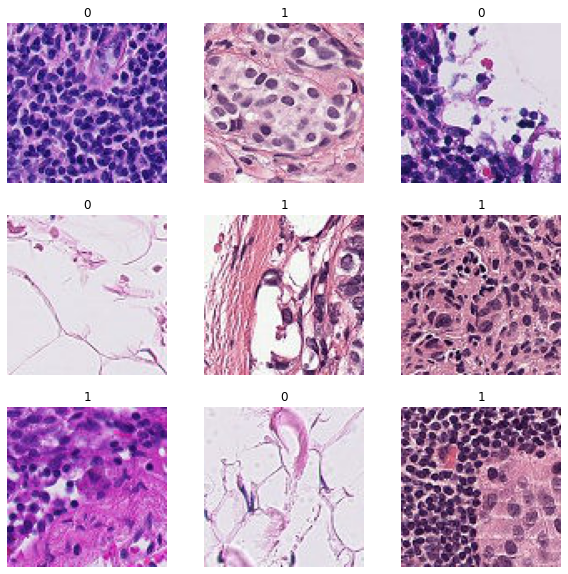

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.ravel()

for images, labels in test_dataset.take(1):
    for i in range(9):
        axs[i].imshow(images[i])
        axs[i].axis('off')
        axs[i].set_title(str(int(labels[i].numpy()[1])))
        print(labels[i].numpy())
plt.show()


The data is then ready to be applied for training, validation, testing etc...below just a very very simple illustration on how to construct and train a model based on the data we have prepared

In [ ]:
def first_ccn_model():
    input_img = Input(shape=(96,96,3))
    
    x = Conv2D(16, (3, 3), padding='valid', activation='relu')(input_img)
    x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    y = Dense(2, activation='softmax')(x)

    model = Model(inputs=input_img, outputs=y)
    return model

sgd_opt = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

model = first_ccn_model()

model.compile(optimizer=sgd_opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(train_dataset,
                 validation_data=validation_dataset,
                 epochs=2)

Epoch 1/2
820/820 [==============================] - 25s 17ms/step - loss: 0.6712 - accuracy: 0.5900 - val_loss: 0.6628 - val_accuracy: 0.5905
Epoch 2/2
820/820 [==============================] - 14s 17ms/step - loss: 0.6186 - accuracy: 0.6446 - val_loss: 0.8224 - val_accuracy: 0.5392


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test accuracy:', test_acc)

103/103 [==============================] - 1s 9ms/step - loss: 0.8163 - accuracy: 0.5233
Test accuracy: 0.5233445167541504


# Functions for heatmaps

In [ ]:
def vis_feature_map(layer,mdl,divider,img):
  print(str(layer))
  # Get the output of the first convolutional layer
  output = mdl.get_layer(layer).output

  # Create a new model that outputs the output of the first convolutional layer
  conv_model = Model(inputs=mdl.input, outputs=output)

  # Use the conv_model to predict the output of the first convolutional layer for the example image
  conv_output = conv_model.predict(np.array([img]))

  # Get the number of filters in the layer
  #num_filters = conv_output.shape[3]+2
  num_filters = 8

  nr_col = int(round(num_filters/divider)+1)

  # Plot the filters
  fig, axes = plt.subplots(int(num_filters/nr_col), nr_col, figsize=(3*nr_col, int(num_filters*3/nr_col)))
  axes = axes.ravel()
  for i in range(num_filters):
      axes[i].imshow(conv_output[0,:,:,i], 
#                     cmap='jet'
                    )
      axes[i].axis('off')
  plt.show()

In [ ]:
def vis_feature_map_aggregated(layer, mdl, img):
  # Get the output of the specified layer
  output = mdl.get_layer(layer).output

  # Create a new model that outputs the output of the specified layer
  conv_model = Model(inputs=mdl.input, outputs=output)

  # Use the conv_model to predict the output of the specified layer for the example image
  conv_output = conv_model.predict(np.array([img]))

  # Get the number of filters in the layer
  num_filters = conv_output.shape[3]

  # Initialize a heatmap with all values set to zero
  heatmap = np.zeros_like(conv_output[0,:,:,0])

  # Sum the activations of all filters in the layer
  for i in range(num_filters):
      heatmap += conv_output[0,:,:,i]

  # Normalize the heatmap
  #heatmap = np.maximum(heatmap, 0)
  #heatmap /= np.max(heatmap)

  heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap + 1))


  # Plot the heatmap
  plt.imshow(heatmap, 
             cmap='jet'
             )
  plt.axis('off')
  plt.show()


# CNN model (chosen architecture)

In [ ]:
def dlss(train,validation,test):
  model = Sequential()
  
  model.add(Conv2D(128, (3, 3), activation="LeakyReLU", input_shape=(96, 96, 3)))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  
  model.add(Conv2D(128, (3, 3), activation="LeakyReLU"))
  model.add(MaxPooling2D(pool_size = (2, 2)))

  model.add(Conv2D(128, (3, 3), activation="LeakyReLU"))
  model.add(MaxPooling2D(pool_size = (2, 2)))

  model.add(Conv2D(256, (3, 3), activation="LeakyReLU"))
  model.add(MaxPooling2D(pool_size = (2, 2)))

  model.add(Flatten())
  model.add(Dense(activation = 'relu', units = 128))
  model.add(Dense(activation = 'relu', units = 64))
  model.add(Dense(activation = 'softmax', units = 2))

  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

  earlystopper = EarlyStopping(monitor = 'val_loss',
                               patience = 10,
                               verbose = 1,
                               restore_best_weights = True)

  reducel = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, min_lr=0.0001)

  checkpoint = ModelCheckpoint(filepath='validated_model.h5', save_best_only=True)

  # Train the model
  history = model.fit(train,
                      epochs = 100,
                      validation_data = validation,
                      callbacks=[reducel, earlystopper, checkpoint])    

  # Evaluate the model
  test_loss, test_acc = model.evaluate(test)
  print('Test accuracy:', test_acc)

  # Plot the training and validation accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc = 'upper left')
  plt.show()

  # Plot the training and validation loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc = 'upper left')
  plt.show()

  return model


Epoch 1/100
820/820 [==============================] - 27s 32ms/step - loss: 0.5322 - accuracy: 0.7411 - val_loss: 0.4901 - val_accuracy: 0.7623 - lr: 0.0010
Epoch 2/100
820/820 [==============================] - 24s 30ms/step - loss: 0.4755 - accuracy: 0.7847 - val_loss: 0.5181 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 3/100
820/820 [==============================] - 25s 31ms/step - loss: 0.4455 - accuracy: 0.8009 - val_loss: 0.4793 - val_accuracy: 0.7901 - lr: 0.0010
Epoch 4/100
820/820 [==============================] - 25s 31ms/step - loss: 0.3938 - accuracy: 0.8289 - val_loss: 0.4154 - val_accuracy: 0.8190 - lr: 0.0010
Epoch 5/100
820/820 [==============================] - 24s 30ms/step - loss: 0.3452 - accuracy: 0.8545 - val_loss: 0.6436 - val_accuracy: 0.6704 - lr: 0.0010
Epoch 6/100
820/820 [==============================] - 25s 30ms/step - loss: 0.2899 - accuracy: 0.8827 - val_loss: 0.4558 - val_accuracy: 0.8001 - lr: 0.0010
Epoch 7/100
820/820 [==============================]

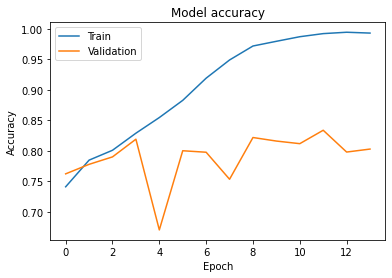

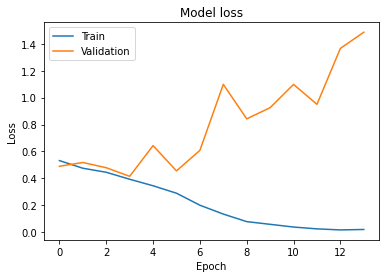

In [ ]:
model2 = dlss(train_dataset,validation_dataset,test_dataset)

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 94, 94, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 128)      0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 45, 45, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 20, 20, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 128)      0

Visualizing the weights (kernels)

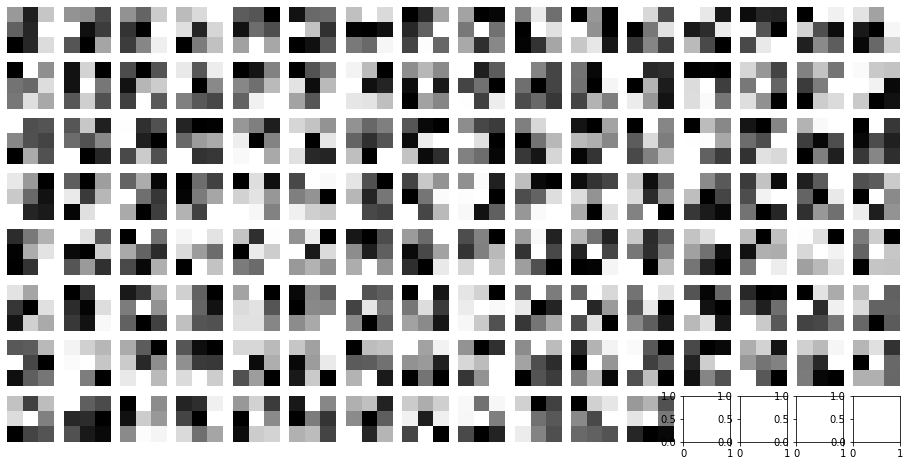

In [ ]:
# Get the weights for the first convolutional layer
weights = model2.layers[0].get_weights()[0]

# Get the number of filters in the layer
num_filters = weights.shape[3]
nr_col = int(round(num_filters/8))

# Plot the filters
fig, axes = plt.subplots(num_filters//nr_col, nr_col, figsize=(nr_col, num_filters//nr_col))
axes = axes.ravel()
for i in range(num_filters-4):
    axes[i].imshow(weights[:,:,0,i], cmap='gray')
    axes[i].axis('off')
plt.show()


[0. 1.]


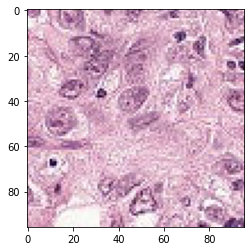

In [ ]:
# Get the first image from the dataset
for image, label in train_dataset.take(1):
    is_cancer = image.numpy()[0]
    l_cancer = label.numpy()[0]
    print(l_cancer)

    plt.imshow(is_cancer)
    plt.show()

[1. 0.]


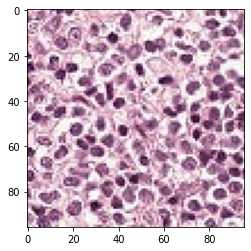

In [ ]:
# Get the first image from the dataset
for image, label in train_dataset.take(1):
    n_cancer = image.numpy()[0]
    l_n_cancer = label.numpy()[0]
    print(l_n_cancer)

    plt.imshow(n_cancer)
    plt.show()

In [ ]:
from tensorflow import keras

is_cancer = np.array(keras.preprocessing.image.load_img("is_cancer1.png").resize((96,96)))
n_cancer = np.array(keras.preprocessing.image.load_img("healthy.png").resize((96,96)))

CANCER
conv2d_2
1/1 [==============================] - 0s 35ms/step


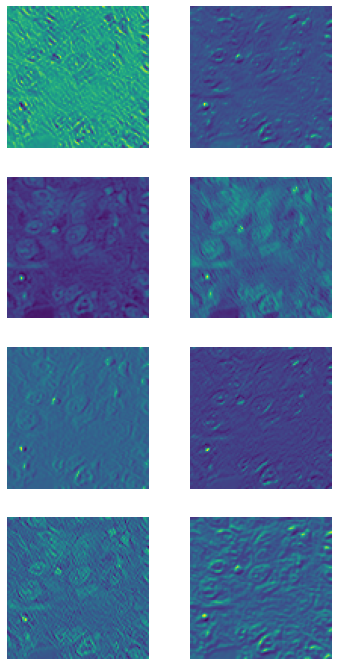

IS NOT CANCER
conv2d_2
1/1 [==============================] - 0s 34ms/step


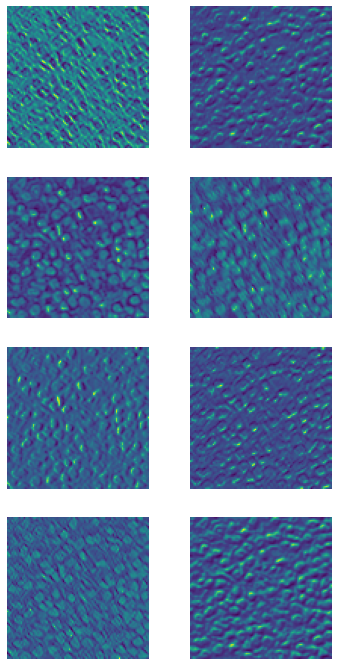

CANCER
conv2d_3
1/1 [==============================] - 0s 39ms/step


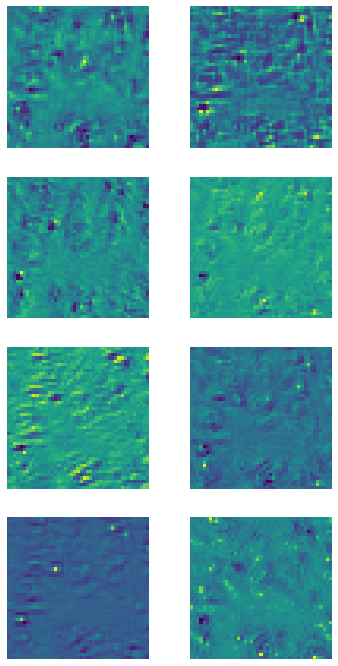

IS NOT CANCER
conv2d_3
1/1 [==============================] - 0s 40ms/step


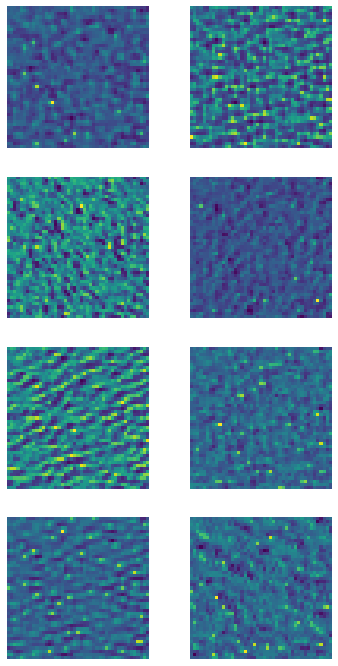

CANCER
conv2d_4
1/1 [==============================] - 0s 45ms/step


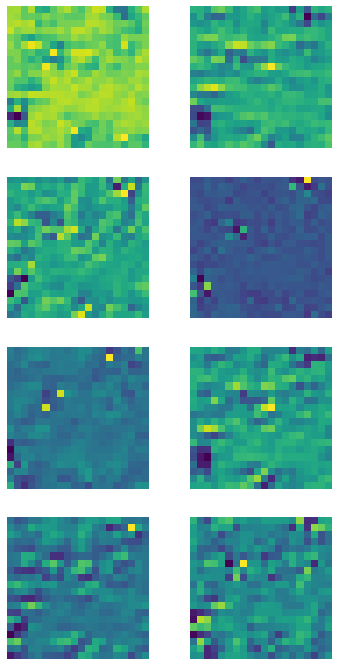

IS NOT CANCER
conv2d_4
1/1 [==============================] - 0s 45ms/step


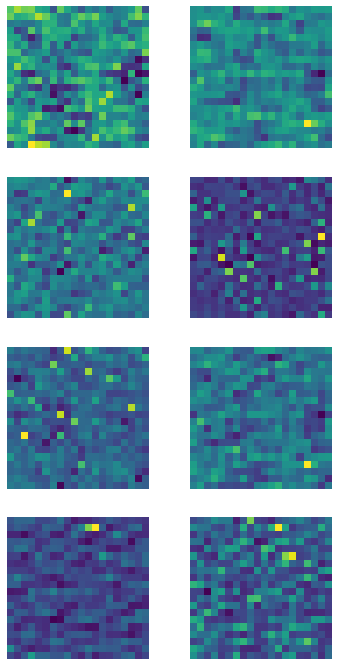

CANCER
conv2d_5
1/1 [==============================] - 0s 55ms/step


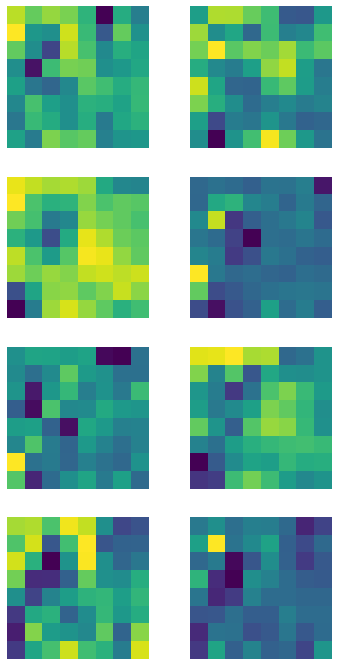

IS NOT CANCER
conv2d_5
1/1 [==============================] - 0s 55ms/step


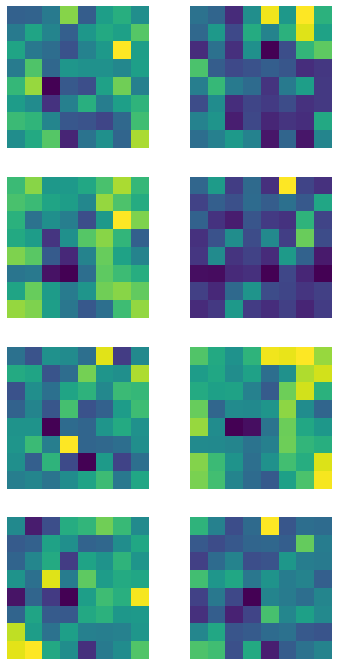

In [ ]:
conv_layers = ['conv2d_2','conv2d_3','conv2d_4','conv2d_5']

for i in conv_layers:
  print("CANCER")
  vis_feature_map(i,model2,8,is_cancer)
  print("IS NOT CANCER")
  vis_feature_map(i,model2,8,n_cancer)

CANCER
1/1 [==============================] - 0s 32ms/step


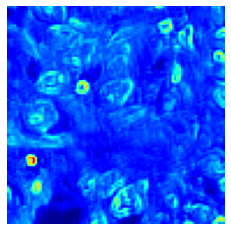

IS NOT CANCER
1/1 [==============================] - 0s 31ms/step


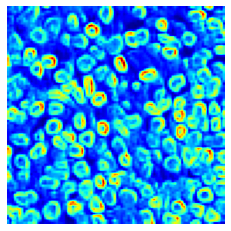

CANCER
1/1 [==============================] - 0s 37ms/step


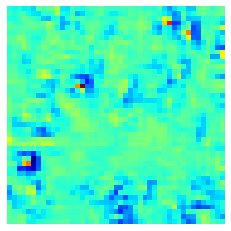

IS NOT CANCER
1/1 [==============================] - 0s 41ms/step


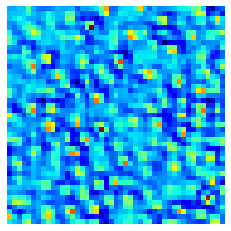

CANCER
1/1 [==============================] - 0s 47ms/step


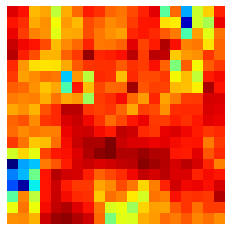

IS NOT CANCER
1/1 [==============================] - 0s 49ms/step


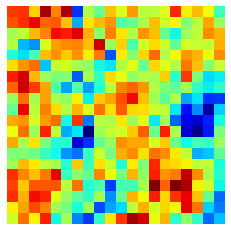

CANCER
1/1 [==============================] - 0s 66ms/step


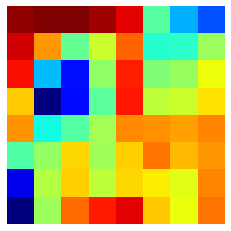

IS NOT CANCER
1/1 [==============================] - 0s 54ms/step


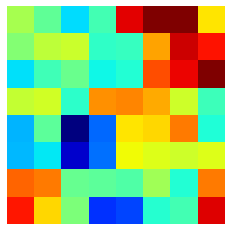

In [ ]:
for i in conv_layers:
  print("CANCER")
  vis_feature_map_aggregated(i,model2,is_cancer)
  print("IS NOT CANCER")
  vis_feature_map_aggregated(i,model2,n_cancer)

# Spatial Transformer Model

In [ ]:
default_zoom=0.5
def initialize_weights(input_nodes: int, default_zoom: float):
    biases = np.zeros((2, 3), dtype='float32')
    biases[0, 0] = default_zoom
    biases[1, 1] = default_zoom
    weights = np.zeros((input_nodes, 6), dtype='float32')
    
    return [weights, biases.flatten()]

loc_input_layer = tf.keras.Input(shape=(96, 96, 3))

x = tf.keras.layers.Conv2D(8, kernel_size=7)(loc_input_layer)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Conv2D(10, kernel_size=5)(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(32, activation='relu')(x) # 32 must match the below function call
x = tf.keras.layers.Dense(6, activation='linear',weights=initialize_weights(32, default_zoom))(x)

x = BilinearInterpolation((96, 96))([loc_input_layer, x]) # Output (96,96,3)

cnn = tf.keras.layers.Conv2D(10, kernel_size=5)(x)

cnn = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(cnn)
cnn=tf.keras.layers.ReLU()(cnn)
cnn=tf.keras.layers.Conv2D(20, kernel_size=5)(cnn)
cnn=tf.keras.layers.SpatialDropout2D(0.2)(cnn)
cnn=tf.keras.layers.MaxPool2D(pool_size=(2, 2))(cnn)
cnn=tf.keras.layers.ReLU()(cnn)
cnn=tf.keras.layers.Flatten()(cnn)
cnn=tf.keras.layers.Dense(50, activation='relu')(cnn)
cnn=tf.keras.layers.Dropout(0.2)(cnn)
out = tf.keras.layers.Dense(2, activation='softmax')(cnn)
 
spatial_transform = tf.keras.models.Model(
    inputs=loc_input_layer, outputs=out, name='spatial_transformer',
)

spatial_transform.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


Epoch 1/100
820/820 [==============================] - 20s 22ms/step - loss: 0.6635 - accuracy: 0.6085 - val_loss: 0.6098 - val_accuracy: 0.6717 - lr: 0.0010
Epoch 2/100
820/820 [==============================] - 16s 19ms/step - loss: 0.5541 - accuracy: 0.7235 - val_loss: 0.5309 - val_accuracy: 0.7309 - lr: 0.0010
Epoch 3/100
820/820 [==============================] - 15s 18ms/step - loss: 0.5241 - accuracy: 0.7488 - val_loss: 0.5327 - val_accuracy: 0.7415 - lr: 0.0010
Epoch 4/100
820/820 [==============================] - 16s 19ms/step - loss: 0.5092 - accuracy: 0.7622 - val_loss: 0.5117 - val_accuracy: 0.7556 - lr: 0.0010
Epoch 5/100
820/820 [==============================] - 15s 19ms/step - loss: 0.4981 - accuracy: 0.7706 - val_loss: 0.5442 - val_accuracy: 0.7461 - lr: 0.0010
Epoch 6/100
820/820 [==============================] - 16s 19ms/step - loss: 0.4855 - accuracy: 0.7777 - val_loss: 0.5093 - val_accuracy: 0.7501 - lr: 0.0010
Epoch 7/100
820/820 [==============================]

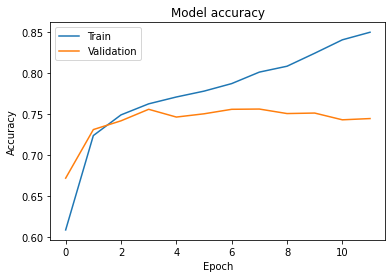

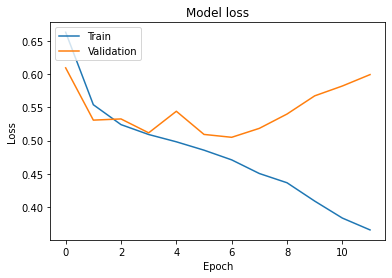

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('spatial_transform.h5', save_best_only=True, save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
callbacks = [early_stop, checkpoint, reduce_lr]

hist_stn = spatial_transform.fit(train_dataset, 
                                 validation_data=validation_dataset,
                                 epochs=100, verbose=1,
                                 callbacks=callbacks)

# Evaluate the model
test_loss, test_acc = spatial_transform.evaluate(test_dataset)
print('Test accuracy:', test_acc)

# Plot the training and validation accuracy
plt.plot(hist_stn.history['accuracy'])
plt.plot(hist_stn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

# Plot the training and validation loss
plt.plot(hist_stn.history['loss'])
plt.plot(hist_stn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()


In [ ]:
spatial_transform.summary()

Model: "spatial_transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 90, 90, 8)    1184        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 45, 45, 8)    0           ['conv2d_2[0][0]']               
                                                                                                  
 re_lu (ReLU)                   (None, 45, 45, 8)    0           ['max_pooling2d[0][0]']          
                                                                                

CANCER
conv2d_2
1/1 [==============================] - 0s 32ms/step


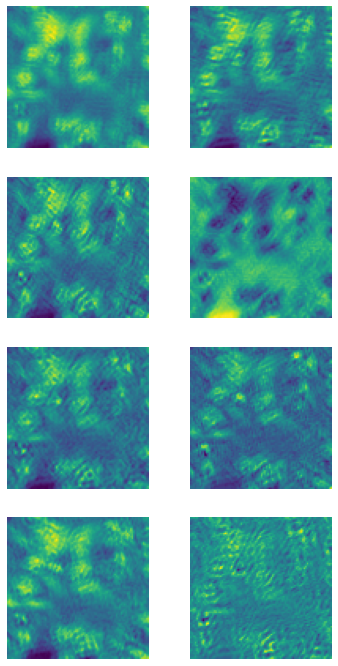

IS NOT CANCER
conv2d_2
1/1 [==============================] - 0s 35ms/step


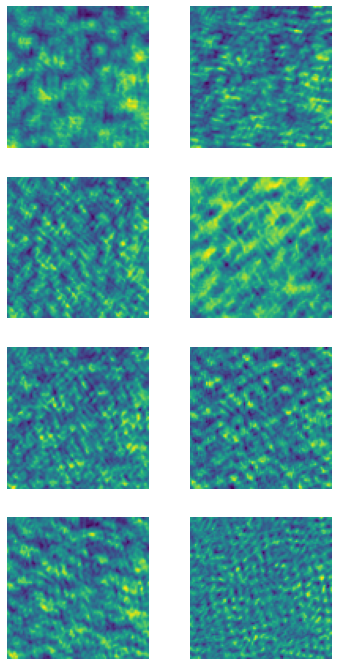

CANCER
conv2d_3
1/1 [==============================] - 0s 50ms/step


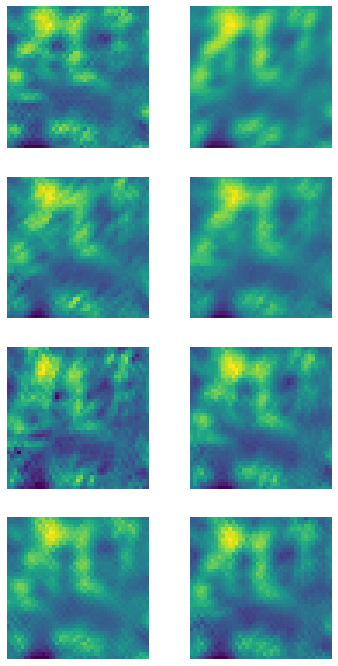

IS NOT CANCER
conv2d_3
1/1 [==============================] - 0s 39ms/step


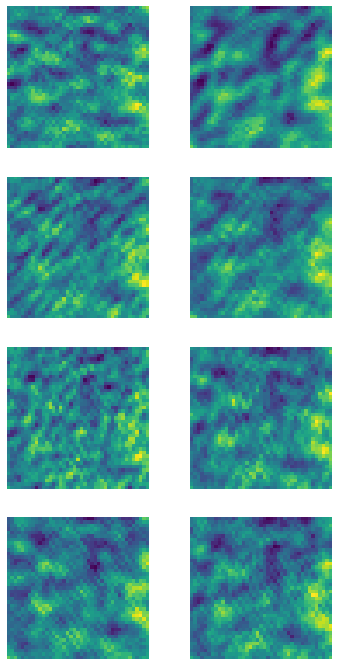

CANCER
conv2d_4
1/1 [==============================] - 1s 683ms/step


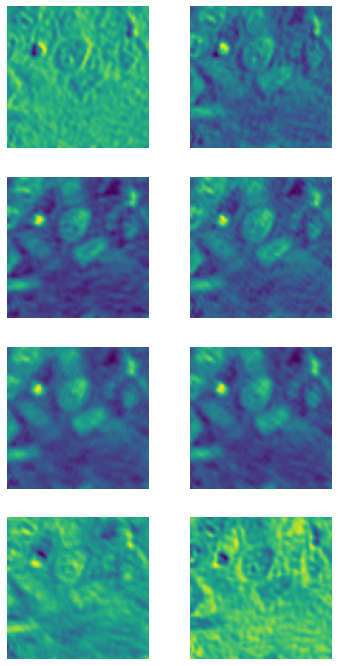

IS NOT CANCER
conv2d_4
1/1 [==============================] - 1s 712ms/step


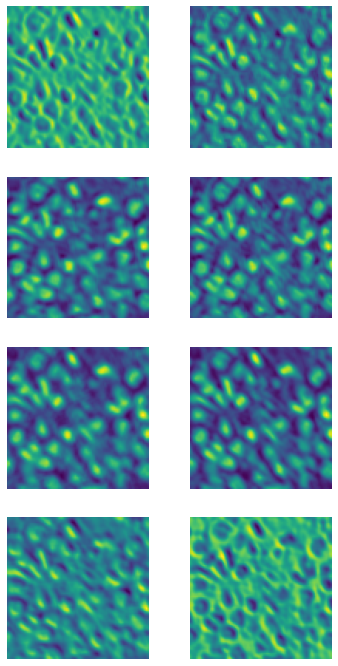

CANCER
conv2d_5
1/1 [==============================] - 1s 740ms/step


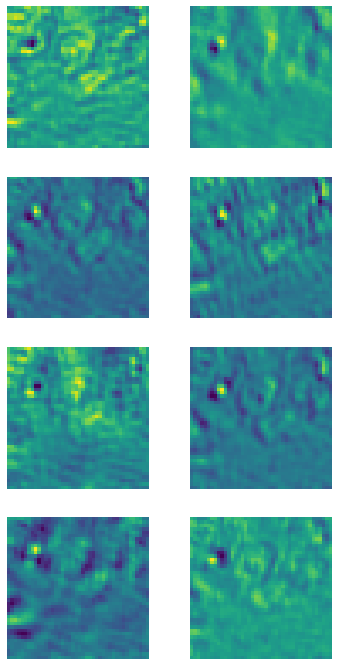

IS NOT CANCER
conv2d_5
1/1 [==============================] - 1s 742ms/step


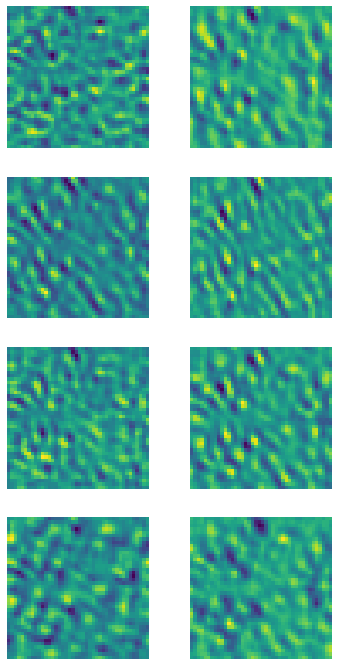

In [ ]:
conv_layers = ['conv2d_2','conv2d_3','conv2d_4','conv2d_5']

for i in conv_layers:
  print("CANCER")
  vis_feature_map(i,spatial_transform,8,is_cancer)
  print("IS NOT CANCER")
  vis_feature_map(i,spatial_transform,8,n_cancer)

CANCER
1/1 [==============================] - 0s 30ms/step


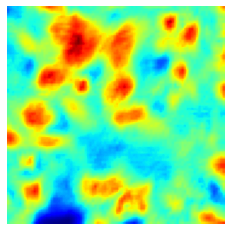

IS NOT CANCER
1/1 [==============================] - 0s 28ms/step


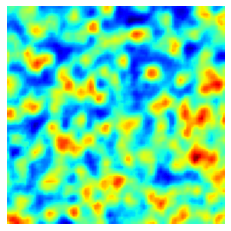

CANCER
1/1 [==============================] - 0s 36ms/step


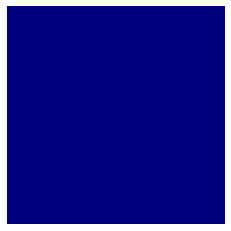

IS NOT CANCER
1/1 [==============================] - 0s 36ms/step


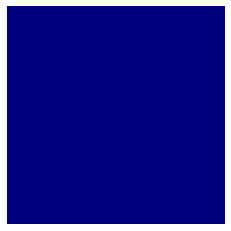

CANCER
1/1 [==============================] - 1s 709ms/step


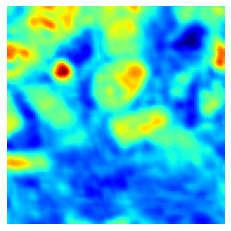

IS NOT CANCER
1/1 [==============================] - 1s 697ms/step


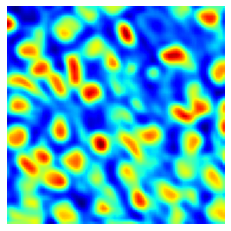

CANCER
1/1 [==============================] - 1s 688ms/step


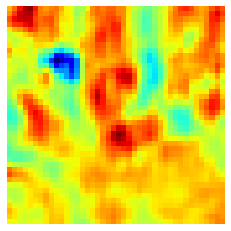

IS NOT CANCER
1/1 [==============================] - 1s 765ms/step


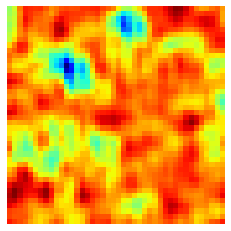

In [ ]:
conv_layers_spat = ['conv2d_6','conv2d_7','conv2d_8','conv2d_9']


for i in conv_layers_spat:
  print("CANCER")
  vis_feature_map_aggregated(i,spatial_transform,is_cancer)
  print("IS NOT CANCER")
  vis_feature_map_aggregated(i,spatial_transform,n_cancer)

# Model with NO callbacks and NO regularization (Appendix 4a)

In [ ]:
def cnn_no_callbacks():
  model = Sequential()
  
  model.add(Conv2D(128, (3, 3), activation="LeakyReLU", input_shape=(96, 96, 3)))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  
  model.add(Conv2D(128, (3, 3), activation="LeakyReLU"))
  model.add(MaxPooling2D(pool_size = (2, 2)))

  model.add(Conv2D(128, (3, 3), activation="LeakyReLU"))
  model.add(MaxPooling2D(pool_size = (2, 2)))

  model.add(Conv2D(256, (3, 3), activation="LeakyReLU"))
  model.add(MaxPooling2D(pool_size = (2, 2)))

  model.add(Conv2D(256, (3, 3), activation="LeakyReLU"))
  model.add(MaxPooling2D(pool_size = (2, 2)))

  model.add(Flatten())
  model.add(Dense(activation = 'relu', units = 128))
  model.add(Dense(activation = 'relu', units = 64))
  model.add(Dense(activation = 'softmax', units = 2))

  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


  # Train the model
  history = model.fit(train_dataset,
                      epochs = 40,
                      validation_data = validation_dataset)
  # Evaluate the model
  test_loss, test_acc = model.evaluate(test_dataset)
  print('Test accuracy:', test_acc)

  # Plot the training and validation accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc = 'upper left')
  plt.show()

  # Plot the training and validation loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc = 'upper left')
  plt.show()

  return model


Epoch 1/40
820/820 [==============================] - 26s 31ms/step - loss: 0.5659 - accuracy: 0.7072 - val_loss: 0.4958 - val_accuracy: 0.7605
Epoch 2/40
820/820 [==============================] - 26s 31ms/step - loss: 0.4861 - accuracy: 0.7766 - val_loss: 0.4508 - val_accuracy: 0.7910
Epoch 3/40
820/820 [==============================] - 26s 31ms/step - loss: 0.4401 - accuracy: 0.8038 - val_loss: 0.4156 - val_accuracy: 0.8047
Epoch 4/40
820/820 [==============================] - 26s 31ms/step - loss: 0.3825 - accuracy: 0.8333 - val_loss: 0.3794 - val_accuracy: 0.8306
Epoch 5/40
820/820 [==============================] - 26s 31ms/step - loss: 0.3291 - accuracy: 0.8618 - val_loss: 0.3927 - val_accuracy: 0.8248
Epoch 6/40
820/820 [==============================] - 25s 31ms/step - loss: 0.2673 - accuracy: 0.8906 - val_loss: 0.4061 - val_accuracy: 0.8322
Epoch 7/40
820/820 [==============================] - 25s 31ms/step - loss: 0.1971 - accuracy: 0.9227 - val_loss: 0.8262 - val_accuracy:

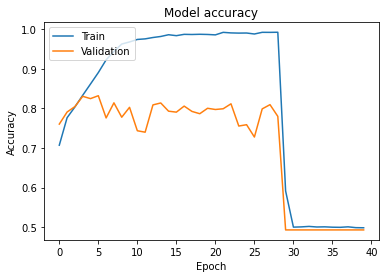

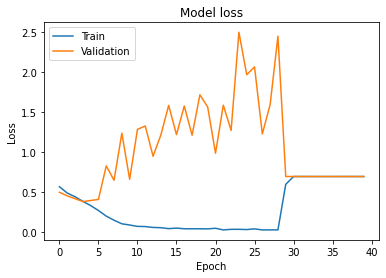

In [ ]:
model_cnn_nc = cnn_no_callbacks()

# Model with no callbacks but with Dropout and Batch Normalizations (Appendix 4b)

In [ ]:
def cnn_no_callbacks_drop_bn():
  model = Sequential()
  
  model.add(Conv2D(128, (3, 3), activation="LeakyReLU", input_shape=(96, 96, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.2))
  
  model.add(Conv2D(128, (3, 3), activation="LeakyReLU"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, (3, 3), activation="LeakyReLU"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(256, (3, 3), activation="LeakyReLU"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(256, (3, 3), activation="LeakyReLU"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(activation = 'relu', units = 128))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(activation = 'relu', units = 64))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(activation = 'softmax', units = 2))

  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
  # Train the model
  history = model.fit(train_dataset,
                      epochs = 40,
                      validation_data = validation_dataset)
  # Evaluate the model
  test_loss, test_acc = model.evaluate(test_dataset)
  print('Test accuracy:', test_acc)

  # Plot the training and validation accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc = 'upper left')
  plt.show()

  # Plot the training and validation loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc = 'upper left')
  plt.show()

  return model


In [ ]:
model_cnn_nc_d_bn = cnn_no_callbacks_drop_bn()

# Model with Regularization and Callbacks (Appendix 4d)

In [ ]:
def cnn_allin():
  model = Sequential()
  
  model.add(Conv2D(128, (3, 3), activation="LeakyReLU", input_shape=(96, 96, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.2))
  
  model.add(Conv2D(128, (3, 3), activation="LeakyReLU"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, (3, 3), activation="LeakyReLU"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(256, (3, 3), activation="LeakyReLU"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(256, (3, 3), activation="LeakyReLU"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(activation = 'relu', units = 128))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(activation = 'relu', units = 64))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(activation = 'softmax', units = 2))

  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

  earlystopper = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1, restore_best_weights = True)

  reducel = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, min_lr=0.0001)

  checkpoint = ModelCheckpoint(filepath='validated_model.h5', save_best_only=True)

  # Train the model
  history = model.fit(train_dataset,
                      epochs = 100,
                      validation_data = validation_dataset,
                      callbacks=[reducel, earlystopper, checkpoint])    

  # Evaluate the model
  test_loss, test_acc = model.evaluate(test_dataset)
  print('Test accuracy:', test_acc)

  # Plot the training and validation accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc = 'upper left')
  plt.show()

  # Plot the training and validation loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc = 'upper left')
  plt.show()

  return model

Epoch 1/100
820/820 [==============================] - 38s 44ms/step - loss: 0.4966 - accuracy: 0.7733 - val_loss: 0.6046 - val_accuracy: 0.7190 - lr: 0.0010
Epoch 2/100
820/820 [==============================] - 35s 43ms/step - loss: 0.4307 - accuracy: 0.8085 - val_loss: 0.5090 - val_accuracy: 0.7278 - lr: 0.0010
Epoch 3/100
820/820 [==============================] - 35s 43ms/step - loss: 0.3985 - accuracy: 0.8254 - val_loss: 0.4592 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 4/100
820/820 [==============================] - 35s 42ms/step - loss: 0.3761 - accuracy: 0.8389 - val_loss: 0.6306 - val_accuracy: 0.7040 - lr: 0.0010
Epoch 5/100
820/820 [==============================] - 35s 42ms/step - loss: 0.3603 - accuracy: 0.8438 - val_loss: 0.7614 - val_accuracy: 0.6704 - lr: 0.0010
Epoch 6/100
820/820 [==============================] - 35s 42ms/step - loss: 0.3369 - accuracy: 0.8572 - val_loss: 0.6871 - val_accuracy: 0.7016 - lr: 8.0000e-04
Epoch 7/100
820/820 [===========================

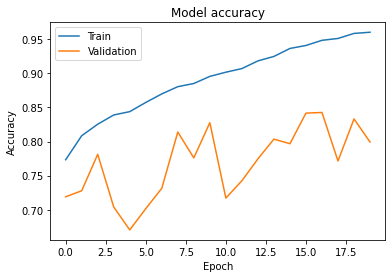

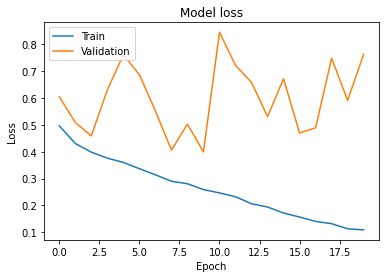

In [ ]:
cnn_all_in_model = cnn_allin()

# Model with Data Augumentation (Image Data Generator, Appendix 5)

In [ ]:
# Create an ImageDataGenerator for the train dataset
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
)

In [ ]:
# Create an empty list to store the augmented data
augmented_data = []

# Iterate through the train dataset, one batch at a time
for x_batch, y_batch in train_dataset:
    # Use the ImageDataGenerator to augment the data
    x_augmented, y_augmented = next(train_datagen.flow(x_batch, y_batch, batch_size=32))
    # Append the augmented data to the list
    augmented_data.append((x_augmented, y_augmented))

# Concatenate the augmented data into a single tensor
x_augmented = tf.concat([x for x, y in augmented_data], axis=0)
y_augmented = tf.concat([y for x, y in augmented_data], axis=0)

# Create a generator for the augmented data
train_generator = tf.data.Dataset.from_tensor_slices((x_augmented, y_augmented)).batch(32)


[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]


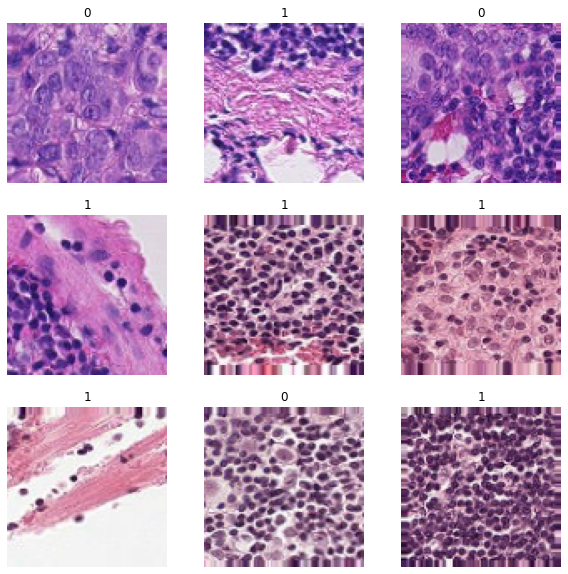

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.ravel()

for images, labels in train_generator.take(1):
    for i in range(9):
        axs[i].imshow(images[i])
        axs[i].axis('off')
        axs[i].set_title(str(int(labels[i].numpy()[1])))
        print(labels[i].numpy())
plt.show()

Epoch 1/100
820/820 [==============================] - 26s 31ms/step - loss: 0.5442 - accuracy: 0.7319 - val_loss: 0.5869 - val_accuracy: 0.7446 - lr: 0.0010
Epoch 2/100
820/820 [==============================] - 26s 31ms/step - loss: 0.4750 - accuracy: 0.7824 - val_loss: 0.5807 - val_accuracy: 0.7363 - lr: 0.0010
Epoch 3/100
820/820 [==============================] - 25s 30ms/step - loss: 0.4330 - accuracy: 0.8080 - val_loss: 0.7807 - val_accuracy: 0.6298 - lr: 0.0010
Epoch 4/100
820/820 [==============================] - 26s 31ms/step - loss: 0.3919 - accuracy: 0.8279 - val_loss: 0.4921 - val_accuracy: 0.7690 - lr: 0.0010
Epoch 5/100
820/820 [==============================] - 24s 30ms/step - loss: 0.3605 - accuracy: 0.8438 - val_loss: 0.5813 - val_accuracy: 0.7467 - lr: 0.0010
Epoch 6/100
820/820 [==============================] - 25s 30ms/step - loss: 0.3167 - accuracy: 0.8663 - val_loss: 0.5573 - val_accuracy: 0.7678 - lr: 0.0010
Epoch 7/100
820/820 [==============================]

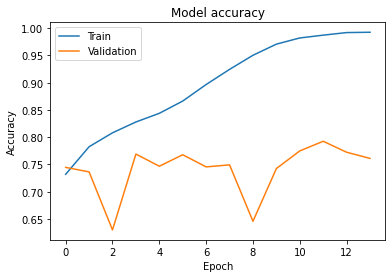

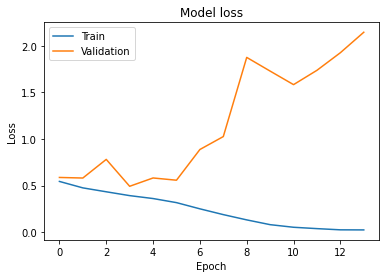

In [ ]:
model_img_dat_gen = dlss(train_generator,validation_dataset,test_dataset)

# Transfer learning

## Res2

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False
    
# Create your own CNN architecture on top of the base model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(activation = 'relu', units = 128))
model.add(Dense(activation = 'relu', units = 64))
model.add(Dense(activation = 'softmax', units = 2))

# Freeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[:40]:
    layer.trainable = True



# Recompile the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

earlystopper = EarlyStopping(monitor = 'val_loss',
                               patience = 8,
                               verbose = 1,
                               restore_best_weights = True)

reducel = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.0001)

#checkpoint = ModelCheckpoint(filepath='tlmodel1.h5', save_best_only=True)

# Fit the model on the dataset again
historyres2 = model.fit(train_dataset, 
                        validation_data = validation_dataset, 
                        epochs = 50, 
                        callbacks=[reducel, earlystopper])

# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print('Test accuracy:', test_acc)

## InceptionResNetV2

In [ ]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False
    
# Create your own CNN architecture on top of the base model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(activation = 'relu', units = 128))
model.add(Dense(activation = 'relu', units = 64))
model.add(Dense(activation = 'softmax', units = 2))

# Freeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[:500]:
    layer.trainable = True

# Recompile the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


earlystopper = EarlyStopping(monitor = 'val_loss',
                               patience = 5,
                               verbose = 1,
                               restore_best_weights = True)

reducel = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.0001)

#checkpoint = ModelCheckpoint(filepath='tlmodel2.h5', save_best_only=True)


# Fit the model on the dataset again
historyinc2 = model.fit(train_dataset, validation_data = validation_dataset, epochs = 50, callbacks=[reducel, earlystopper])

# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print('Test accuracy:', test_acc)